# Turning Dogs to Cats with PGD attack
The following notebook demonstrates an inference time attack on neural image classifier, [PGD](https://arxiv.org/abs/1706.06083), that imperceptibly perturbs a image of a dog to be classified as a _Persian Cat_.

Code is self-contained in the notebook

## Setup

In [10]:
# For colab runs (can comment-out on local runs):
! git clone https://github.com/matanbt/pgd-demo.git

import os
os.chdir("pgd-demo")

In [11]:
from functools import partial
from typing import List

import torchvision
import torch
from PIL import Image
import timm
from tqdm import trange

DOG_IDX = 166  # Walker hound, Walker foxhound
CAT_IDX = 283  # Persian cat
device = 'cuda'
MODEL_NAME = 'eva02_large_patch14_448.mim_m38m_ft_in22k_in1k'
# MODEL_NAME = 'resnet50.a1_in1k'  # can also try on ResNet

In [ ]:
## Util functions:

# Load ImageNet-1K classes
with open("data/imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())


def get_label_text(idx: int) -> str:
    """
    Convert imagenet class (=label) index to class string
    """
    return idx2label[idx]


def get_image(_img_tensor: torch.Tensor):
    """
    Converts tensor image to PIL image object
    """

    if _img_tensor.shape[0] == 1:  # hack
        _img_tensor = _img_tensor[0]

    return torchvision.transforms.ToPILImage()(img_tensor)


def get_logits(_model, _norm_func, _img_tensor, normalize_before=True):
    """
    Runs model; applies norm on the input before run, if needed (`normalize_before`)
    """
    if normalize_before:
        _img_tensor = norm_func(_img_tensor)
    return _model(_img_tensor)

## Load image and model

In [12]:
# Load attacked image:
img = Image.open('data/masha.png').convert('RGB')

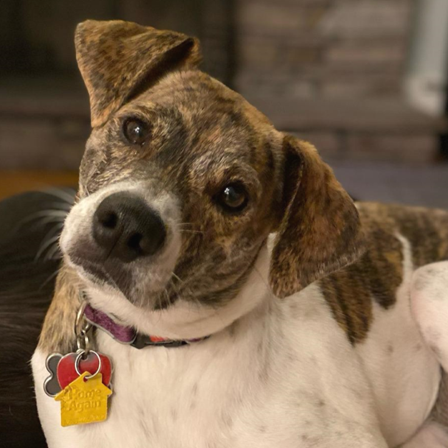

In [13]:
# Load model:
model = timm.create_model(MODEL_NAME, pretrained=True)
model = model.to(device)
model.requires_grad_(False)
model = model.eval()

# prepare model transformations, and separate normalization
data_config = timm.data.resolve_model_data_config(model)
model_transforms = timm.data.create_transform(**data_config, is_training=False)
assert isinstance(model_transforms.transforms[-1], type(model_transforms.transforms[-1]))
init_model_transforms, norm_func = torchvision.transforms.Compose(model_transforms.transforms[:-1]), model_transforms.transforms[-1]
get_logits = partial(_get_logits, model, norm_func)

# transform image to tensor and show it
img_tensor = init_model_transforms(img).unsqueeze(0).to(device)
get_image(img_tensor)

In [14]:
def print_classification(logits: torch.Tensor):
    logits = logits.cpu()
    probabilities = (logits.softmax(dim=-1) * 100)[0]
    
    top_probabilities, top_class_indices = torch.sort(probabilities, descending=True)
    
    for rank, (idx, prob) in enumerate(zip(top_class_indices, top_probabilities)):
        if rank < 5 or idx in [CAT_IDX, DOG_IDX]:
            print(f">> #{rank+1} ({prob.item() :.2f}%):", get_label_text(idx.item()))

In [15]:
# Run classification (before attack):
logits = get_logits(img_tensor)
print_classification(logits)

>> #1 (28.32%): Walker hound, Walker foxhound
>> #2 (12.74%): English foxhound
>> #3 (3.51%): beagle
>> #4 (2.85%): basenji
>> #5 (1.28%): wire-haired fox terrier
>> #894 (0.02%): Persian cat


## Attack Algorithm

In [16]:
"""
PGD in the paper 'Towards Deep Learning Models Resistant to Adversarial Attacks'
[https://arxiv.org/abs/1706.06083]

Distance Measure : Linf

# Reference code: https://github.com/Harry24k/adversarial-attacks-pytorch
"""


def pgd(
        images: torch.Tensor,  # (n_batch, n_channel, height, width); in range [0,1]
        labels: List[int],  # (n_batch,)

        # attack parameters:
        eps: float = 5 / 255,  #  maximum perturbation
        alpha: float = 1 / 255,  # step size
        steps: int = 100,  # number of steps
):

    images = images.clone().detach().to(device)  
    target_labels = torch.tensor(labels).clone().detach().to(device)  # (n_batch,)
    adv_images = images.clone().detach()
    
    
    loss = torch.nn.CrossEntropyLoss()
    
    # [OPTIONAL] Starting at a uniformly random point
    # adv_images = adv_images + torch.empty_like(adv_images).uniform_(
    #     -eps, eps
    # )
    
    adv_images = torch.clamp(adv_images, min=0, max=1).detach()
    
    for _ in trange(steps):
        adv_images.requires_grad = True
        
        logits = get_logits(adv_images)
    
        # Calculate loss
        cost = loss(logits, target_labels)  # targeted attack; decent on it
    
        # Update adversarial images, while ensuring it remains an image
        grad = torch.autograd.grad(
            cost, adv_images, retain_graph=False, create_graph=False
        )[0]
        adv_images = adv_images.detach() - alpha * grad.sign()
        delta = torch.clamp(adv_images - images, min=-eps, max=eps)
        adv_images = torch.clamp(images + delta, min=0, max=1).detach()
        
    return adv_images

## Run Attack

100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


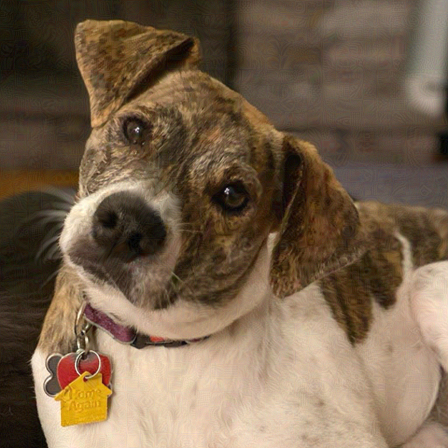

In [17]:
# Run the attack
adv_img_tensor = pgd(img_tensor, [CAT_IDX])

get_image(adv_img_tensor)

In [18]:
# Run classification (after attack):
logits = get_logits(adv_img_tensor)
print_classification(logits)

>> #1 (97.35%): Persian cat
>> #2 (0.06%): Angora, Angora rabbit
>> #3 (0.06%): tabby, tabby cat
>> #4 (0.04%): lynx, catamount
>> #5 (0.03%): chow, chow chow
>> #950 (0.00%): Walker hound, Walker foxhound
